### CNN Image Classification Problem 

Identifying Refugee Camps in the Middle East

Here the objective is to train a CNN on satellite images to identify refugee camps in the Middle East.  Here we are dealing with a real world problem and a limited amount of data.  We'll use a data augmentation feature to suplement our existing dataset.  

In [1]:
from keras.models import Sequential
from keras.layers import Dense
import numpy as np 
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
import os, sys
import itertools, functools
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import scale, LabelBinarizer
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.utils import class_weight
from skimage.io import imread, imshow
from skimage.transform import resize

# Random seed for numpy
np.random.seed(18937)
from keras.models import Model
from keras.layers import Input
from keras.layers.core import Dense, Dropout, Reshape
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions

import os
import argparse
from shutil import copy
from pathlib import Path
from multiprocessing import Pool, TimeoutError

Using TensorFlow backend.


In [66]:
# functions to create folders and copy files 
import os


def create_fold_dirs(output_path, num_folds):
    """
    Create train and test directories in output path
    :param output_path: Path to the output
    :param num_folds: the number of folds
    """
    for i in range(num_folds):
        for word in ["train", "test"]:
            os.mkdir(os.path.join(str(output_path), word + "_fold" + chr(65+i)))
    

def copy_file(file, source, output):
    f = file
    full_path = os.path.join(source, f)
    full_output= os.path.join(output, f)
    folder = full_output[:full_output.rfind("/")]
    if not Path(folder).exists():
        Path(folder).mkdir()
    if not Path(full_output).exists():
        print("Copying...{}".format(f))
        copy(full_path, full_output)    
           

In [77]:
img_dir = '/dsa/home/jamgtn/experimental/data/refugee_camp_data/Noncamp'
out_path2 = '/dsa/home/jamgtn/experimental/data/refugee_camp_data/n_test/noncamp'
i = 0
for filename in os.listdir(img_dir):
    if filename.endswith("10.png"): 
        copy_file(filename, img_dir, out_path2)
        #print(os.path.join(img_dir, filename))
        continue
    else:
        continue  

#############################
#    i += 1
#    if i > 2050:
#        break  # otherwise the generator would loop indefinitely

Copying...noncamp,altinozu,36.35925,36.17987-chip10.png
Copying...noncamp,altinozu,36.35925,36.18570-chip10.png
Copying...noncamp,altinozu,36.37371,36.19153-chip10.png
Copying...noncamp,altinozu,36.37371,36.18570-chip10.png
Copying...noncamp,altinozu,36.37371,36.17987-chip10.png
Copying...noncamp,altinozu,36.36648,36.19153-chip10.png
Copying...noncamp,altinozu,36.36648,36.18570-chip10.png
Copying...noncamp,altinozu,36.36648,36.17987-chip10.png
Copying...noncamp,altinozu,36.35925,36.19153-chip10.png
Copying...noncamp,apaydin,36.35856,36.23933-chip10.png
Copying...noncamp,apaydin,36.35855,36.23349-chip10.png
Copying...noncamp,apaydin,36.35855,36.22766-chip10.png
Copying...noncamp,apaydin,36.35132,36.23933-chip10.png
Copying...noncamp,apaydin,36.35132,36.23349-chip10.png
Copying...noncamp,apaydin,36.35132,36.22766-chip10.png
Copying...noncamp,apaydin,36.34409,36.23933-chip10.png
Copying...noncamp,apaydin,36.34409,36.23349-chip10.png
Copying...noncamp,apaydin,36.34409,36.22766-chip10.png
C

## Data Augmentation 

In [ ]:
# this cell is not used in the model, just here to demonstrate how datagen works.  

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.0,
        zoom_range=0.0,
        horizontal_flip=True,
        fill_mode='nearest')

img = load_img('/dsa/home/jamgtn/experimental/data/refugee_camp_data/n_test/noncamp/noncamp,altinozu,36.35925,36.17987-chip10.png')  # this is a PIL image
x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

print(x)

print(x.shape)

train = '/dsa/home/jamgtn/experimental/data/refugee_camp_data/train'

# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `preview/` directory
i = 0
for batch in datagen.flow(x, batch_size=1,
                          save_to_dir=train, save_prefix='camps', save_format='png'):
    i += 1
    if i > 50:
        break  # otherwise the generator would loop indefinitely

In [3]:
# let's take a peak at the files in the directory

obj =[]

import os
indir = '/dsa/home/jamgtn/experimental/data/refugee_camp_data/n_train/noncamp'
for root, dirs, filenames in os.walk(indir):
    for f in filenames:
        #print(f)
        obj = print(f)

noncamp,karkamis,38.03530,36.87465-chip05.png
noncamp,malatya_beydagi,38.15119,38.33291-chip05.png
noncamp,karkamis,38.02071,36.86882-chip05.png
noncamp,malatya_beydagi,38.17351,38.35624-chip05.png
noncamp,suruc,38.55222,36.92028-chip05.png
noncamp,malatya_beydagi,38.14376,38.33874-chip05.png
noncamp,kahmanaras_turkoglu,36.97824,37.57041-chip05.png
noncamp,malatya_beydagi,38.17350,38.33874-chip05.png
noncamp,islahiye,36.61867,36.97753-chip05.png
noncamp,kahmanaras_turkoglu,36.98559,37.57041-chip05.png
noncamp,king_abdullah_park,36.02617,32.52403-chip05.png
noncamp,altinozu,36.37371,36.19153-chip05.png
noncamp,malatya_beydagi,38.15863,38.34457-chip05.png
noncamp,malatya_beydagi,38.15863,38.33291-chip05.png
noncamp,malatya_beydagi,38.15863,38.35040-chip05.png
noncamp,malatya_beydagi,38.12888,38.33874-chip05.png
noncamp,apaydin,36.35132,36.22766-chip05.png
noncamp,malatya_beydagi,38.13632,38.34457-chip05.png
noncamp,kahmanaras_turkoglu,36.97088,37.56458-chip05.png
noncamp,apaydin,36.35132

### Let's examine some of the actual images 

Showing the train/camp karkamis image, full path : /dsa/home/jamgtn/experimental/data/refugee_camp_data/n_train/camp/camp,karkamis,38.02801,36.87465-chip13.png


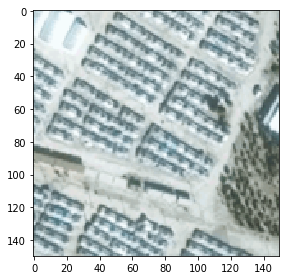

In [4]:
DATASET = lambda fname = '': os.path.join('/dsa/home/jamgtn/experimental/data/refugee_camp_data/n_train', fname)
assert os.path.exists(DATASET())

plt.figure()

print("Showing the train/camp karkamis image, full path : {}".format(
            DATASET('camp/camp,karkamis,38.02801,36.87465-chip13.png')
        )
     )

imshow(imread(DATASET('camp/camp,karkamis,38.02801,36.87465-chip13.png')))

#### Take a look at one of the noncamp images 


(150, 150, 3)

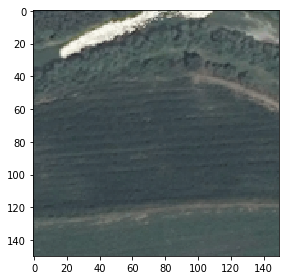

In [5]:
imshow(imread(DATASET('noncamp/noncamp,apaydin,36.35856,36.23933-chip05.png')))
imread(DATASET('noncamp/noncamp,apaydin,36.35856,36.23933-chip05.png')).shape

In [6]:
import os

# count instances of noncamp in our training directory
DIR = '/dsa/home/jamgtn/experimental/data/refugee_camp_data/n_train/noncamp'
print("Noncamp Training Images:",len([name for name in os.listdir(DIR) if os.path.isfile(os.path.join(DIR, name))]))

# count instances of camp in our training directory
DIR = '/dsa/home/jamgtn/experimental/data/refugee_camp_data/n_train/camp'
print("Camp Training Images:",len([name for name in os.listdir(DIR) if os.path.isfile(os.path.join(DIR, name))]))


# count instances of noncamp in our testing directory
DIR = '/dsa/home/jamgtn/experimental/data/refugee_camp_data/n_test/noncamp'
print("Noncamp Test Images",len([name for name in os.listdir(DIR) if os.path.isfile(os.path.join(DIR, name))]))

# count instances of camp in our testing directory
DIR = '/dsa/home/jamgtn/experimental/data/refugee_camp_data/n_test/camp'
print("Camp Test Images:",len([name for name in os.listdir(DIR) if os.path.isfile(os.path.join(DIR, name))]))


Noncamp Training Images: 80
Camp Training Images: 28
Noncamp Test Images 40
Camp Test Images: 11


## Build our CNN Model 




In [7]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

z = load_img('/dsa/home/jamgtn/experimental/data/refugee_camp_data/n_test/noncamp/noncamp,altinozu,36.35925,36.17987-chip10.png')  # this is a PIL image
x = img_to_array(z)  # this is a Numpy array with shape (3, 150, 150)
print(x.shape)

n_col = x.shape
print(n_col)

xt = np.transpose(x)
inputs = Input(shape=(784,))

n_col

(150, 150, 3)
(150, 150, 3)


(150, 150, 3)

In [8]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(n_col))) # n_col is defined by the shape above 
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

In [9]:
model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [10]:
batch_size = 50

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        '/dsa/home/jamgtn/experimental/data/refugee_camp_data/n_train',  # this is the target directory
        target_size=(150, 150),  # all images will be resized to 150x150
        batch_size=batch_size,
        class_mode='binary')  # since we use binary_crossentropy loss, we need binary labels

# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
        '/dsa/home/jamgtn/experimental/data/refugee_camp_data/n_test',
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')


Found 108 images belonging to 2 classes.
Found 51 images belonging to 2 classes.


In [11]:
#class_weights = {0 : 1.,
#    1: 50.,
#    2: 2.}

#There are 74% images which are class 1, and 26% images which are class 0.  
#I balance 2 classes using the class_weights
class_weights = {0:74,1:26}

model.fit_generator(
        train_generator,
        steps_per_epoch=2881 // batch_size,
        epochs=10,
        class_weight=class_weights,
        validation_data=validation_generator,
        validation_steps=1184 // batch_size)
# model.save_weights('first_try.h5')  #  save weights after training or during training

Epoch 1/10
57/57 [==============================] - 93s - loss: 19.9489 - acc: 0.6581 - val_loss: 0.2548 - val_acc: 0.9411
Epoch 2/10
57/57 [==============================] - 91s - loss: 7.0277 - acc: 0.9483 - val_loss: 0.1888 - val_acc: 0.9413
Epoch 3/10
57/57 [==============================] - 91s - loss: 3.0771 - acc: 0.9791 - val_loss: 0.1703 - val_acc: 0.9413
Epoch 4/10
57/57 [==============================] - 91s - loss: 1.6515 - acc: 0.9883 - val_loss: 0.1624 - val_acc: 0.9413
Epoch 5/10
57/57 [==============================] - 88s - loss: 0.4673 - acc: 0.9961 - val_loss: 0.2806 - val_acc: 0.9413
Epoch 6/10
57/57 [==============================] - 89s - loss: 1.4639 - acc: 0.9894 - val_loss: 0.2623 - val_acc: 0.9413
Epoch 7/10
57/57 [==============================] - 89s - loss: 0.4061 - acc: 0.9943 - val_loss: 0.3052 - val_acc: 0.9609
Epoch 8/10
57/57 [==============================] - 89s - loss: 0.2600 - acc: 0.9961 - val_loss: 0.3459 - val_acc: 0.9591
Epoch 9/10
57/57 [=====

In [61]:
model.save_weights('first_try.h5')  #  save weights after training or during training
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
activation_6 (Activation)    (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
activation_7 (Activation)    (None, 72, 72, 32)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 34, 34, 64)        18496     
__________

In [147]:
validation_generator.class_indices

{'camp': 0, 'noncamp': 1}

## Model 1 Evaluation

### Look at what the model is predicting 

Here we will load up some of the testing images and see if the model predicts that there is a refugee camp present or if there is no refugee camp.  

But first check the model accuracy and loss/error.  We will evaluate the model using  **validation_generator** to provide data.

In [62]:
loss, accuracy = model.evaluate_generator(validation_generator, steps = 800 // batch_size)
print('loss:', loss, 'accuracy:', accuracy)

loss: 0.360584131068 accuracy: 0.961180124501


50/50 [==============================] - 0s     
[[ 9  2]
 [ 1 38]]


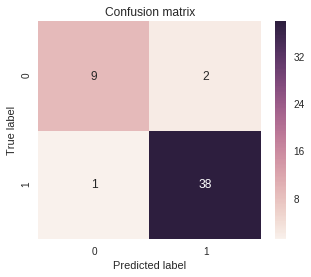

In [12]:
for batch in itertools.islice(validation_generator, 200):
    X_test, y_test = batch

y_preds = model.predict(X_test)
#y_preds = np.argmax(y_pred, axis=1) + 1

#print(y_preds)
predictions = model.predict_classes(X_test)
#print(predictions2)

preds = []
for i in predictions:
    preds.extend(i)

classification_report(y_test, preds)
cm = confusion_matrix(y_test, preds)
print(cm)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize = (5,4))
cm = confusion_matrix(y_test, preds)
sns.heatmap(cm, annot = True)
plt.title('Confusion matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [13]:
report = classification_report(y_test, preds)
print(report)

             precision    recall  f1-score   support

        0.0       0.90      0.82      0.86        11
        1.0       0.95      0.97      0.96        39

avg / total       0.94      0.94      0.94        50



0.89627039627


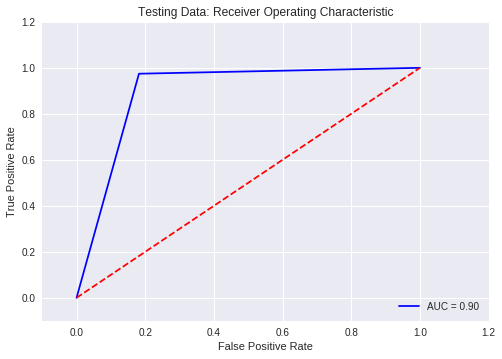

In [14]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score

####ROC curve 
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, preds)
roc_auc = auc(false_positive_rate, true_positive_rate)
print(roc_auc)

plt.title('Testing Data: Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [184]:
print(get_category_id(y_pred).shape)
print(get_category_id(y_test))
print(y_true_sparse)
#print(y_pred_sparse.shape)

(1,)
1
[1, 1, 3, 1, 1, 2, 4, 1, 1, 1, 1, 1, 1, 2, 2, 1]


In [237]:
print(X_test.shape)
print(y_test)
print(np.array(y_test))
#list(predictions2)

x = []
for i in predictions2:
    x.extend(i)

np.array(x)    

(16, 150, 150, 3)
[ 1.  1.  1.  1.  0.  0.  1.  0.  0.  1.  1.  1.  1.  1.  1.  1.]
[ 1.  1.  1.  1.  0.  0.  1.  0.  0.  1.  1.  1.  1.  1.  1.  1.]


array([1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

### Test the model on some images 

Now let's see images and the predicted labels 

Model Prediction: Refugee Camp


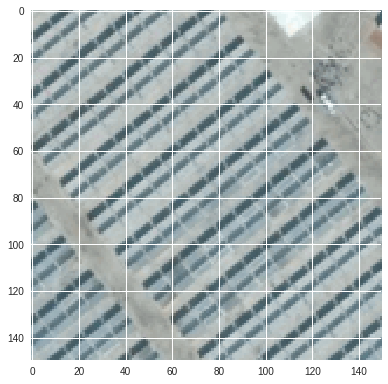

In [15]:
im_test = imread(DATASET('/dsa/home/jamgtn/experimental/data/refugee_camp_data/n_test/camp/camp,malatya_beydagi,38.15119,38.33874-chip02.png'))
imshow(im_test)
im_test = resize(im_test, (150, 150), mode = 'reflect')
y_pred = model.predict(np.expand_dims(im_test, 0)).squeeze()
print(['Model Prediction: Refugee Camp', 'Model Prediction: Noncamp'][y_pred>=0.5])


Model Prediction: Noncamp


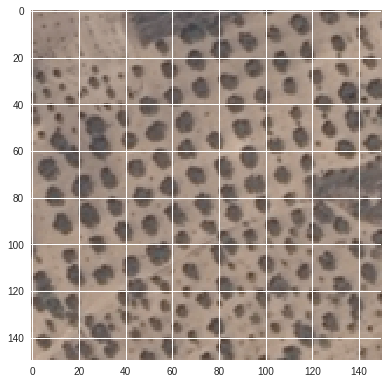

In [16]:
im_test = imread(DATASET('/dsa/home/jamgtn/experimental/data/refugee_camp_data/n_test/noncamp/noncamp,altinozu,36.35925,36.17987-chip10.png'))
imshow(im_test)
im_test = resize(im_test, (150, 150), mode = 'reflect')
y_pred = model.predict(np.expand_dims(im_test, 0)).squeeze()
print(['Model Prediction: Refugee Camp', 'Model Prediction: Noncamp'][y_pred>=0.5])


Model Prediction: Refugee Camp


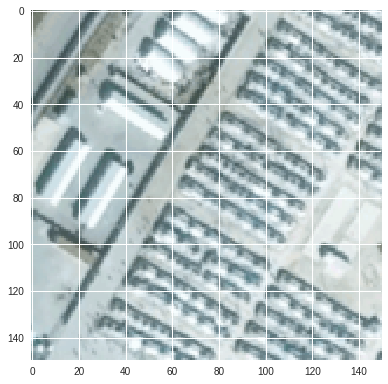

In [17]:
im_test = imread(DATASET('/dsa/home/jamgtn/experimental/data/refugee_camp_data/n_test/camp/camp,karkamis,38.02801,36.87465-chip06.png'))
imshow(im_test)
im_test = resize(im_test, (150, 150), mode = 'reflect')
y_pred = model.predict(np.expand_dims(im_test, 0)).squeeze()
print(['Model Prediction: Refugee Camp', 'Model Prediction: Noncamp'][y_pred>=0.5])


Model Prediction: Noncamp


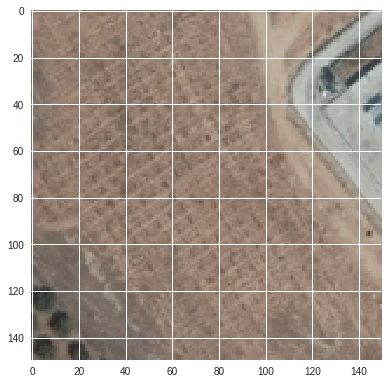

In [18]:
im_test = imread(DATASET('/dsa/home/jamgtn/experimental/data/refugee_camp_data/n_test/camp/part,malatya_beydagi,38.15119,38.33874-chip00.png'))
imshow(im_test)
im_test = resize(im_test, (150, 150), mode = 'reflect')
y_pred = model.predict(np.expand_dims(im_test, 0)).squeeze()
print(['Model Prediction: Refugee Camp', 'Model Prediction: Noncamp'][y_pred>=0.5])


The image above shows a small corner of a refugee camp.  Looks like there is just not enough features for the model to pick up that there is a refugee camp present in this image. 

Model Prediction: Noncamp


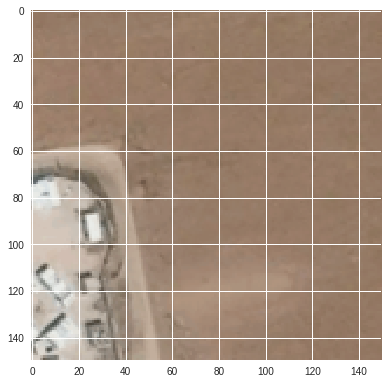

In [19]:
im_test = imread(DATASET('/dsa/home/jamgtn/experimental/data/refugee_camp_data/n_test/camp/part,king_abdullah_park,36.02617,32.52987-chip16.png'))
imshow(im_test)
im_test = resize(im_test, (150, 150), mode = 'reflect')
y_pred = model.predict(np.expand_dims(im_test, 0)).squeeze()
print(['Model Prediction: Refugee Camp', 'Model Prediction: Noncamp'][y_pred>=0.5])


Here we pull up another image where there's only a small portion of a refugee camp.  In this image the refugee camp is slightly more in the frame than the previous image, but it is still hard to tell that there is a refugee camp present.  Yet, in this situation the model picks up that there is a refugee camp present.  

Model Prediction: Refugee Camp


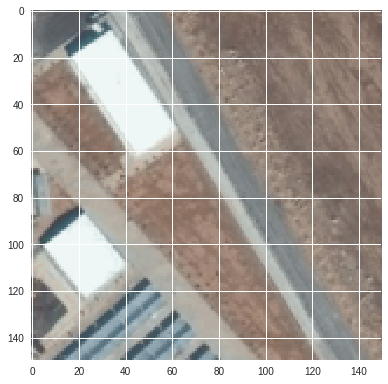

In [20]:
im_test = imread(DATASET('/dsa/home/jamgtn/experimental/data/refugee_camp_data/n_test/camp/part,malatya_beydagi,38.15863,38.33874-chip06.png'))
imshow(im_test)
im_test = resize(im_test, (150, 150), mode = 'reflect')
y_pred = model.predict(np.expand_dims(im_test, 0)).squeeze()
print(['Model Prediction: Refugee Camp', 'Model Prediction: Noncamp'][y_pred>=0.5])


The above image is a coner of a refugee camp.  It is hard to clearly tell if there is a refugee camp present in the image as not all the tents and lines are clear.  In this situation the model predicts that there is a refugee camp present.   

## Model II Transfer Learning Using VGG16

In the section below, we will transfer [VGG Networks](http://www.robots.ox.ac.uk/~vgg/research/very_deep/),
[or academic paper: VGG16](https://arxiv.org/abs/1409.1556) network along with its
weights instead of creating the neural network from scratch.

But we will detach dense layers from VGG16 network and add our own.
During training, all the weights within VGG16 will stay locked, so we'll be using 
whatever features VGG16 gives us.  Only weights in the dense layers will be trained, and this part serves as a classifier.

In [23]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input

images = Input(shape = n_col) # (150,150,3) as shown above

vgg16 = VGG16(weights='imagenet', include_top=False)

# Lock the VGG16 Layers
for layer in vgg16.layers:
    layer.trainable = False   # Look above

classifier = [
    Flatten(input_shape = vgg16.output_shape[1:]),
    
    # Size, and Neuron Type
    Dense(256, activation='relu', name = 'dense_1'),
    Dropout(0.5),

    # Size, and Neuron Type
    Dense(1, activation='softmax', name = 'dense_2'),
]

y_pred = functools.reduce(lambda f1, f2: f2(f1), [images, vgg16]+classifier)

VGG16model = Model(inputs = [images], outputs = [y_pred])

In [402]:
VGG16model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print(VGG16model.summary())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, 150, 150, 3)       0         
_________________________________________________________________
vgg16 (Model)                multiple                  14714688  
_________________________________________________________________
flatten_8 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dropout_8 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
________________________________________________________

In [403]:
batch_size = 16

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(
        '/dsa/home/jamgtn/experimental/data/refugee_camp_data/n_train',  # this is the target directory
        target_size=(150, 150),  # all images will be resized to 150x150
        batch_size=batch_size,
        class_mode='binary')  # since we use binary_crossentropy loss, we need binary labels

# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
        '/dsa/home/jamgtn/experimental/data/refugee_camp_data/n_test',
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')

Found 108 images belonging to 2 classes.
Found 51 images belonging to 2 classes.


In [404]:
#There are 74% images which are class 1, and 26% images which are class 0.  
#I balance 2 classes using the class_weights
class_weights = {0:74,1:26}

VGG16model.fit_generator(
        train_generator,
        steps_per_epoch=2881 // batch_size,
        epochs=10,
        class_weight=class_weights,
        validation_data=validation_generator,
        validation_steps=1184 // batch_size)
# model.save_weights('first_try.h5')  #  save weights after training or during training

Epoch 1/10
180/180 [==============================] - 490s - loss: 306.1274 - acc: 0.7405 - val_loss: 3.4234 - val_acc: 0.7853
Epoch 2/10
180/180 [==============================] - 488s - loss: 304.9031 - acc: 0.7415 - val_loss: 3.4402 - val_acc: 0.7842
Epoch 3/10
180/180 [==============================] - 489s - loss: 307.7617 - acc: 0.7391 - val_loss: 3.4234 - val_acc: 0.7853
Epoch 4/10
180/180 [==============================] - 491s - loss: 305.3174 - acc: 0.7412 - val_loss: 3.4738 - val_acc: 0.7821
Epoch 5/10
180/180 [==============================] - 489s - loss: 307.7617 - acc: 0.7391 - val_loss: 3.4570 - val_acc: 0.7832
Epoch 6/10
180/180 [==============================] - 490s - loss: 305.7202 - acc: 0.7409 - val_loss: 3.4234 - val_acc: 0.7853
Epoch 7/10
180/180 [==============================] - 489s - loss: 304.7696 - acc: 0.7417 - val_loss: 3.4738 - val_acc: 0.7821
Epoch 8/10
180/180 [==============================] - 490s - loss: 306.1368 - acc: 0.7405 - val_loss: 3.3899 - 

In [405]:
VGG16model.save_weights('VGG16model.h5')  #  save weights after training or during training

### Evaluate the VGG Model 

In [406]:
loss, accuracy = VGG16model.evaluate_generator(validation_generator, steps = 800 // batch_size)
print('loss:', loss, 'accuracy:', accuracy)

loss: 3.46573595508 accuracy: 0.782608696161


[[ 0  2]
 [ 0 14]]


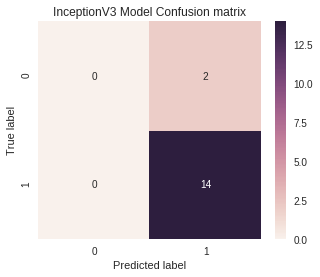

In [410]:
for batch in itertools.islice(validation_generator, 5):
    X_test, y_test = batch

y_preds = VGG16model.predict(X_test)
#y_preds = np.argmax(y_pred, axis=1) + 1

#print(y_preds)

preds = (y_preds>0.5).flatten()
#print(preds)

cm = confusion_matrix(y_test, preds)
print(cm)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize = (5,4))
cm = confusion_matrix(y_test, preds)
sns.heatmap(cm, annot = True)
plt.title('InceptionV3 Model Confusion matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [411]:
report = classification_report(y_test, preds)
print(report)

             precision    recall  f1-score   support

        0.0       0.00      0.00      0.00         2
        1.0       0.88      1.00      0.93        14

avg / total       0.77      0.88      0.82        16



/usr/lib64/python3.4/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.5


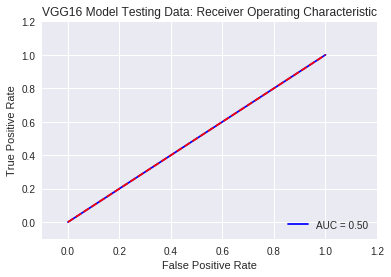

In [412]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score

####ROC curve 
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, preds)
roc_auc = auc(false_positive_rate, true_positive_rate)
print(roc_auc)

plt.title('VGG16 Model Testing Data: Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

We can see from the results, the model isn't going to give us what we want.  In the confusion matrix above it didn't predict any of the images were camps.  

#### Test the model on some images

Model Prediction: Noncamp


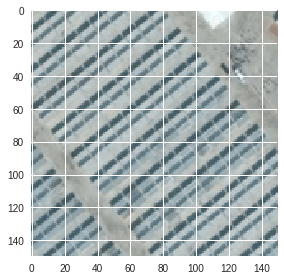

In [413]:
im_test = imread(DATASET('/dsa/home/jamgtn/experimental/data/refugee_camp_data/n_test/camp/camp,malatya_beydagi,38.15119,38.33874-chip02.png'))
imshow(im_test)
im_test = resize(im_test, (150, 150), mode = 'reflect')
y_pred = VGG16model.predict(np.expand_dims(im_test, 0)).squeeze()
print(['Model Prediction: Refugee Camp', 'Model Prediction: Noncamp'][y_pred>=0.5])


We're not off to a good start...this one should have been easy for the model and yet it fails predicting there is no camp present when clearly there is a refugee camp in the image. 

Model Prediction: Noncamp


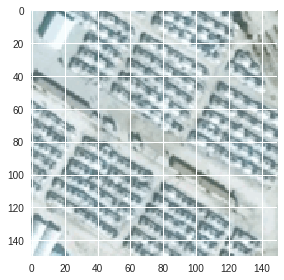

In [414]:
im_test = imread(DATASET('/dsa/home/jamgtn/experimental/data/refugee_camp_data/n_test/camp/camp,karkamis,38.02801,36.87465-chip08.png'))
imshow(im_test)
im_test = resize(im_test, (150, 150), mode = 'reflect')
y_pred = VGG16model.predict(np.expand_dims(im_test, 0)).squeeze()
print(['Model Prediction: Refugee Camp', 'Model Prediction: Noncamp'][y_pred>=0.5])


Owch! This is clearly a refugee camp and the model is getting it wrong. 

Model Prediction: Noncamp


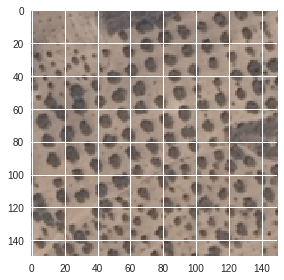

In [415]:
im_test = imread(DATASET('/dsa/home/jamgtn/experimental/data/refugee_camp_data/n_test/noncamp/noncamp,altinozu,36.35925,36.17987-chip10.png'))
imshow(im_test)
im_test = resize(im_test, (150, 150), mode = 'reflect')
y_pred = VGG16model.predict(np.expand_dims(im_test, 0)).squeeze()
print(['Model Prediction: Refugee Camp', 'Model Prediction: Noncamp'][y_pred>=0.5])


The model correctly predicts noncamp for the image above. 

Model Prediction: Noncamp


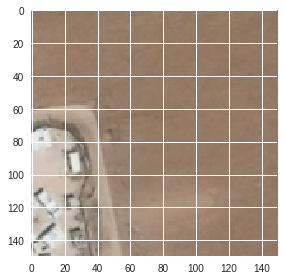

In [416]:
im_test = imread(DATASET('/dsa/home/jamgtn/experimental/data/refugee_camp_data/n_test/camp/part,king_abdullah_park,36.02617,32.52987-chip16.png'))
imshow(im_test)
im_test = resize(im_test, (150, 150), mode = 'reflect')
y_pred = VGG16model.predict(np.expand_dims(im_test, 0)).squeeze()
print(['Model Prediction: Refugee Camp', 'Model Prediction: Noncamp'][y_pred>=0.5])


Here is another challenging image where there is only a corner of a refugee camp present.  The model fails to notice these features and predicts noncamp. 

Model Prediction: Noncamp


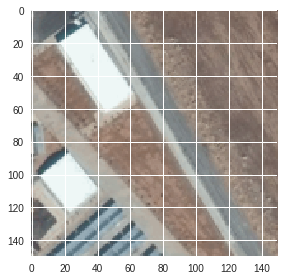

In [417]:
im_test = imread(DATASET('/dsa/home/jamgtn/experimental/data/refugee_camp_data/n_test/camp/part,malatya_beydagi,38.15863,38.33874-chip06.png'))
imshow(im_test)
im_test = resize(im_test, (150, 150), mode = 'reflect')
y_pred = VGG16model.predict(np.expand_dims(im_test, 0)).squeeze()
print(['Model Prediction: Refugee Camp', 'Model Prediction: Noncamp'][y_pred>=0.5])


So definately a challenging image for the model, yet it still fails and predicts noncamp where there are elements of a refugee camp present.  

Model Prediction: Noncamp


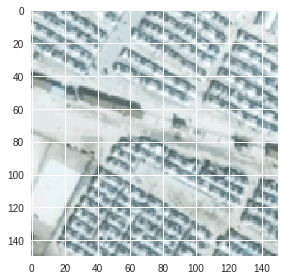

In [418]:
im_test = imread(DATASET('/dsa/home/jamgtn/experimental/data/refugee_camp_data/n_test/camp/camp,karkamis,38.02801,36.87465-chip12.png'))
imshow(im_test)
im_test = resize(im_test, (150, 150), mode = 'reflect')
y_pred = VGG16model.predict(np.expand_dims(im_test, 0)).squeeze()
print(['Model Prediction: Refugee Camp', 'Model Prediction: Noncamp'][y_pred>=0.5])


So the model does not appear to be predicting the images correctly.  

We're not very satisfied with this model given that it's pretty much just predicting noncamp.  

### Model III  Inception Weights 

In [24]:
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K

# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False)

# Lock the Layers
for layer in base_model.layers:
    layer.trainable = False   
classifier = [
    Flatten(input_shape = base_model.output_shape[1:]),
    
    # Size, and Neuron Type
    Dense(256, activation='relu', name = 'dense_1'),
    Dropout(0.5),

    # Size, and Neuron Type
    Dense(1, activation='sigmoid', name = 'dense_2'),
]

y_pred = functools.reduce(lambda f1, f2: f2(f1), [images, base_model]+classifier)

incept_model = Model(inputs = [images], outputs = [y_pred])

In [ ]:
incept_model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print(incept_model.summary())

batch_size = 16

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(
        '/dsa/home/jamgtn/experimental/data/refugee_camp_data/n_train',  # this is the target directory
        target_size=(150, 150),  # all images will be resized to 150x150
        batch_size=batch_size,
        class_mode='binary')  # since we use binary_crossentropy loss, we need binary labels

# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
        '/dsa/home/jamgtn/experimental/data/refugee_camp_data/n_test',
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
inception_v3 (Model)         multiple                  21802784  
_________________________________________________________________
flatten_4 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               4718848   
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 26,521,889
Trainable params: 4,719,105
Non-trainable params: 21,802,784
________________________________________________________

In [ ]:
incept_model.fit_generator(
        train_generator,
        steps_per_epoch=2881 // batch_size,
        epochs=10,
        class_weight=class_weights,
        validation_data=validation_generator,
        validation_steps=1184 // batch_size)


Epoch 1/10
180/180 [==============================] - 466s - loss: 11.2313 - acc: 0.9435 - val_loss: 0.4760 - val_acc: 0.8821
Epoch 3/10
180/180 [==============================] - 457s - loss: 5.2234 - acc: 0.9627 - val_loss: 0.2744 - val_acc: 0.9211
Epoch 4/10
180/180 [==============================] - 459s - loss: 4.4051 - acc: 0.9683 - val_loss: 0.2690 - val_acc: 0.9411
Epoch 5/10
180/180 [==============================] - 456s - loss: 3.2636 - acc: 0.9705 - val_loss: 0.2882 - val_acc: 0.9200
Epoch 6/10
180/180 [==============================] - 457s - loss: 3.1809 - acc: 0.9715 - val_loss: 0.2541 - val_acc: 0.9411
Epoch 7/10
180/180 [==============================] - 454s - loss: 4.7059 - acc: 0.9611 - val_loss: 0.4718 - val_acc: 0.9221
Epoch 8/10
180/180 [==============================] - 461s - loss: 3.5194 - acc: 0.9681 - val_loss: 0.9968 - val_acc: 0.8221
Epoch 9/10
180/180 [==============================] - 457s - loss: 3.8870 - acc: 0.9699 - val_loss: 0.5834 - val_acc: 0.9221

In [360]:
incept_model.save_weights('incept_model.h5')  #  save weights 

In [361]:
loss, accuracy = incept_model.evaluate_generator(validation_generator, steps = 800 // batch_size)
print('loss:', loss, 'accuracy:', accuracy)

loss: 0.494607865701 accuracy: 0.922360248817


### Evaluate the InceptionV3 Model --- Model III

Now let's take a look at some of our evaluation metrics on the model 

In [ ]:
for batch in itertools.islice(validation_generator, 5):
    X_test, y_test = batch

y_preds = incept_model.predict(X_test)
#y_preds = np.argmax(y_pred, axis=1) + 1

#print(y_preds)

preds = (y_preds>0.5).flatten()
#print(preds)

cm = confusion_matrix(y_test, preds)
print(cm)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize = (5,4))
cm = confusion_matrix(y_test, preds)
sns.heatmap(cm, annot = True)
plt.title('InceptionV3 Model Confusion matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [384]:
report = classification_report(y_test, preds)
print(report)


             precision    recall  f1-score   support

        0.0       0.67      1.00      0.80         4
        1.0       1.00      0.83      0.91        12

avg / total       0.92      0.88      0.88        16



0.916666666667


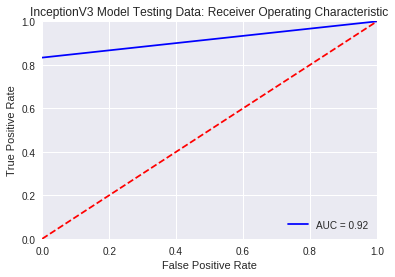

In [392]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score

####ROC curve 
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, preds)
roc_auc = auc(false_positive_rate, true_positive_rate)
print(roc_auc)

plt.title('InceptionV3 Model Testing Data: Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.0,1])
plt.ylim([-0.0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### Test some images on the Incpetionv3 model 

Model Prediction: Refugee Camp


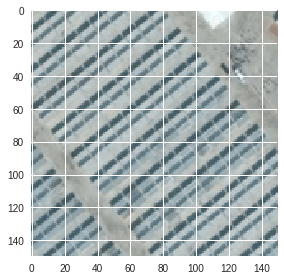

In [393]:
im_test = imread(DATASET('/dsa/home/jamgtn/experimental/data/refugee_camp_data/n_test/camp/camp,malatya_beydagi,38.15119,38.33874-chip02.png'))
imshow(im_test)
im_test = resize(im_test, (150, 150), mode = 'reflect')
y_pred = incept_model.predict(np.expand_dims(im_test, 0)).squeeze()
print(['Model Prediction: Refugee Camp', 'Model Prediction: Noncamp'][y_pred>=0.5])


Model Prediction: Refugee Camp


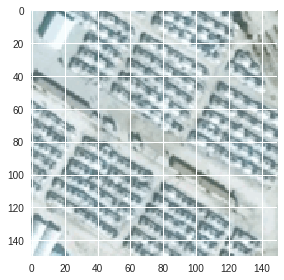

In [394]:
im_test = imread(DATASET('/dsa/home/jamgtn/experimental/data/refugee_camp_data/n_test/camp/camp,karkamis,38.02801,36.87465-chip08.png'))
imshow(im_test)
im_test = resize(im_test, (150, 150), mode = 'reflect')
y_pred = incept_model.predict(np.expand_dims(im_test, 0)).squeeze()
print(['Model Prediction: Refugee Camp', 'Model Prediction: Noncamp'][y_pred>=0.5])


Model Prediction: Noncamp


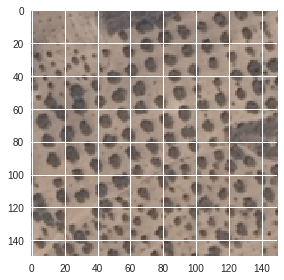

In [395]:
im_test = imread(DATASET('/dsa/home/jamgtn/experimental/data/refugee_camp_data/n_test/noncamp/noncamp,altinozu,36.35925,36.17987-chip10.png'))
imshow(im_test)
im_test = resize(im_test, (150, 150), mode = 'reflect')
y_pred = incept_model.predict(np.expand_dims(im_test, 0)).squeeze()
print(['Model Prediction: Refugee Camp', 'Model Prediction: Noncamp'][y_pred>=0.5])


Model Prediction: Refugee Camp


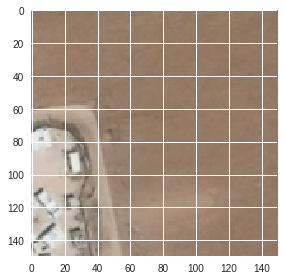

In [396]:
im_test = imread(DATASET('/dsa/home/jamgtn/experimental/data/refugee_camp_data/n_test/camp/part,king_abdullah_park,36.02617,32.52987-chip16.png'))
imshow(im_test)
im_test = resize(im_test, (150, 150), mode = 'reflect')
y_pred = incept_model.predict(np.expand_dims(im_test, 0)).squeeze()
print(['Model Prediction: Refugee Camp', 'Model Prediction: Noncamp'][y_pred>=0.5])


Notice in the image above the model predicts there is a refugee camp present.  Arguably this is tough call because only a small corner of the camp is present.  In our training data we included a number of images that just had portions of refugee camps present.  

Model Prediction: Noncamp


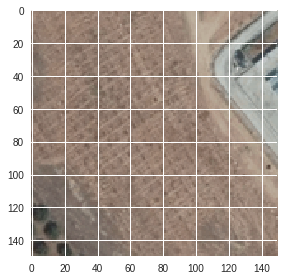

In [397]:
im_test = imread(DATASET('/dsa/home/jamgtn/experimental/data/refugee_camp_data/n_test/camp/part,malatya_beydagi,38.15119,38.33874-chip00.png'))
imshow(im_test)
im_test = resize(im_test, (150, 150), mode = 'reflect')
y_pred = incept_model.predict(np.expand_dims(im_test, 0)).squeeze()
print(['Model Prediction: Refugee Camp', 'Model Prediction: Noncamp'][y_pred>=0.5])


Here is another image where only a small portion of a refugee camp is present in the image.  The model predicts there is no refugee camp.  In reality it is hard to tell even with the human eye that this could actually be a refugee camp.  

Model Prediction: Refugee Camp


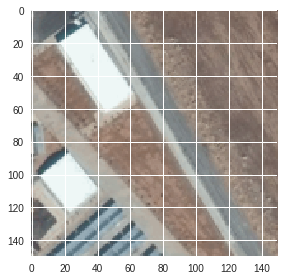

In [399]:
im_test = imread(DATASET('/dsa/home/jamgtn/experimental/data/refugee_camp_data/n_test/camp/part,malatya_beydagi,38.15863,38.33874-chip06.png'))
imshow(im_test)
im_test = resize(im_test, (150, 150), mode = 'reflect')
y_pred = incept_model.predict(np.expand_dims(im_test, 0)).squeeze()
print(['Model Prediction: Refugee Camp', 'Model Prediction: Noncamp'][y_pred>=0.5])


Here is another image that really tests the model we built.  There's elements of a refugee camp present, but even with the human eye it is hard to tell this is actually a refugee camp.  

Model Prediction: Refugee Camp


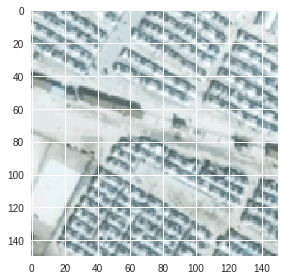

In [400]:
im_test = imread(DATASET('/dsa/home/jamgtn/experimental/data/refugee_camp_data/n_test/camp/camp,karkamis,38.02801,36.87465-chip12.png'))
imshow(im_test)
im_test = resize(im_test, (150, 150), mode = 'reflect')
y_pred = incept_model.predict(np.expand_dims(im_test, 0)).squeeze()
print(['Model Prediction: Refugee Camp', 'Model Prediction: Noncamp'][y_pred>=0.5])


Clearly the image above is a refugee camp.  The model correctly classifiies this images as a refugee camp. 



### Final Thoughts 

This was an interesting project I took on to get some more experience with Keras, convolutional neural networks, and image classification.  I am sure there are some amateur elements to this workflow, but hopefully it's a good starting point for getting more experience with these important tools in data science.  

I got the idea for this project while I was working at the International Commission for Missing Persons.  We were doing analytics on issues related the Syrian conflict in the Middle East.  One of the challenges the organization was facing was connecting with refugees in neighboring countries to complete their work.  Refugee camps serve as a logical place to start, but in reality most refugees are not living in refugee camps.  For example in Lebanon which hosts nearly 1.5 million Syrian refugees there are no official refugee camps.  Without someone on the ground it would be nice to find a tech solution to more strategically connect with these refugees.  I'm pretty sure the model here would not be the best tool to identify informal refugee camps as they might actually have different features than the formal camps with tents and clear borders.  But maybe this is a start.  

Also as we're thinking about tech and machine learning solutions related to this problem one could also point out that its possible to measure the changes in size of the camps and possibly estimate the population of each camp. This also sounds like a really interesting project and another way we could employ data science to gain additional insights to this issue.  Ideally this would be a next step.  

As far as this model goes, I'm pretty sure it's not ready for deployment :-)  Ideally, we'd want to test it on another set of images and probably train it on additional images.  In some ways this data set is almost like a toy data set.  One of our main challenges is that our data set is relatively small.  This is because there are actually very few refugee camps that exist in the real world.  In some ways this is like a real world problem where we're trying to predict something like fraud that's somewhat uncommon.  In my data set I had several thousand image clips of places that were not refugee camps and only a few images that actually contained elements of refugee camps.  To deal with this minority class imbalance problem, I ended up training a model on fewer images (down sampling) and balancing the classes by adjusting the weights on the model.

Some other potential issues with the model might include the fact that we trained it based on the geography of the Middle East.  Most of these images are from areas near refugee camps in Iraq, Turkey and Jordan.  Therefore our noncamp categories generally represent arid environments. This might cause problems if we started feeding the model images from different types of environments - even environments that are semi-urban.  Ultimately, we would want to outline all of these assumptions and test the model againt them to better understand where our model works best and where it performs poorly. This step is an important part of data science when dealing with real world problems. 

In conclusion, if I were to choose one of the three models to continue working with I'd choose the third model.  The model trained on InceptionV3 architecture.  It represents a deeper CNN and the evaluation scores are relatively good.  In a real world setting we might actually want the model filtering images to a human where the model does most of the work.  This might require adjusting the settings so we get more false positives and a human could do more investigating to determine if there was actually a refugee camp present.  

In the end - I'd like to give a special thanks to Dr. Grant Scott and Alex Yang who encouraged me to take on this project and helped me think through the workflow when I was stuck.  Also Dr. Scott was helpful in aquiring this unquie data set from the Digital Globe Foundation.  

Special thanks to the Digital Globe Foundation 


http://foundation.digitalglobe.com/